In [1]:
import os
import numpy as np
import pyarrow as pa

from astropy.time import Time
from adam_core.time import Timestamp
from adam_core.orbits import Orbits
from adam_core.orbits.query import query_sbdb
from adam_core.orbits.variants import VariantOrbits


object_id = '2020 VW' # Potential impactor
# object_id = '2012 DA14' # NEO with close approach (came within geostationary satellite distance in 2013)
# object_id = '2013 RR165' # Simple MBA
out_dir = object_id

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

orbits = query_sbdb([object_id])

if object_id == '2020 VW':
    # 2020 VW has a cumulative impact probability of 1 in 140 
    # See: https://cneos.jpl.nasa.gov/sentry/details.html#?des=2020%20VW
    # 2020 VW's first impact date is 2074-11-02.86 
    first_impact_date = Time("2074-11-03T00:00:00.000", format="isot")

    # Create an array of times from 30 years before impact to the first impact date
    times = Timestamp.from_mjd(np.arange(first_impact_date.tdb.mjd - 365 * 30, first_impact_date.tdb.mjd, 5), scale="tdb")

else:
    # Create an array of times 
    times = Timestamp.from_mjd(np.arange(59000, 60000, 5), scale="tdb")

# Generate monte-carlo samples of of the orbit
num_samples = 1000
variants = VariantOrbits.create(orbits, method="monte-carlo", num_samples=num_samples)
variants = Orbits.from_kwargs(
    orbit_id=pa.array(np.array([f"{i + 1:06}" for i in range(len(variants))])),
    object_id=variants.object_id,
    coordinates=variants.coordinates,
)

/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [2]:
# Inspect the orbit
orbits.to_dataframe()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,00000,(2020 VW),0.691519,0.769024,-0.006089,-0.007969,0.012513,-0.000779,59165,0,"[9.51178202860719e-10, 2.416193597526327e-10, ...",SUN


In [3]:
# Show the first 10 variants
variants.to_dataframe().head()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,000001,(2020 VW),0.691548,0.769031,-0.006092,-0.007966,0.012514,-0.000779,59165,0,None,SUN
1,000002,(2020 VW),0.691544,0.769030,-0.006092,-0.007966,0.012513,-0.000779,59165,0,None,SUN
2,000003,(2020 VW),0.691545,0.769030,-0.006092,-0.007966,0.012513,-0.000779,59165,0,None,SUN
3,000004,(2020 VW),0.691474,0.769012,-0.006084,-0.007974,0.012511,-0.000778,59165,0,None,SUN
4,000005,(2020 VW),0.691555,0.769033,-0.006093,-0.007965,0.012514,-0.000779,59165,0,None,SUN


In [4]:
propagated_orbit_file = os.path.join(out_dir, "propagated_orbit.parquet")
propagated_variants_file = os.path.join(out_dir, "propagated_variants.parquet")

# File does not exist, so propagate the orbit (needs PYOORB installed and configured)
if not os.path.exists(propagated_orbit_file):

    from adam_core.propagator import PYOORB

    propagator = PYOORB()

    # Propagate the orbit (mean state)
    propagated_orbit = propagator.propagate_orbits(
        orbits, 
        times
    )
    propagated_orbit = propagated_orbit.sort_by(["coordinates.time.days", "coordinates.time.nanos"])

    # Propagate the variants
    propagated_variants = propagator.propagate_orbits(
        variants, 
        times, 
        max_processes=20, 
        chunk_size=100
    )
    propagated_variants = propagated_variants.sort_by(["coordinates.time.days", "coordinates.time.nanos", "orbit_id"])


    # Reconstruct the covariance matrix for the mean state from the variants
    propagated_variants_ = VariantOrbits.from_kwargs(
        orbit_id=pa.array(np.full(len(propagated_variants), "00000")),
        object_id=propagated_variants.object_id,
        coordinates=propagated_variants.coordinates,
        # These weights are only valid for monte-carlo samples
        weights=np.full(len(propagated_variants), 1 / num_samples),
        weights_cov=np.full(len(propagated_variants), 1 / num_samples),
    )
    propagated_orbit_ = propagated_variants_.collapse(propagated_orbit)
    propagated_orbit = propagated_orbit.set_column("coordinates.covariance", propagated_orbit_.coordinates.covariance)

    # Save the propagated orbit and variants
    propagated_orbit.to_parquet(propagated_orbit_file)
    propagated_variants.to_parquet(propagated_variants_file)

else:
    propagated_orbit = Orbits.from_parquet(propagated_orbit_file)
    propagated_variants = VariantOrbits.from_parquet(propagated_variants_file)

/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 2190 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 219000 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 219000 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/moeyensj/software/anaconda3/envs/adam_core_py311/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 219000 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_nam

In [5]:
# The propagated orbit (mean state)
propagated_orbit.to_dataframe().head()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,00000,(2020 VW),0.481611,0.990232,-0.023261,-0.011089,0.007877,-0.000705,67929,69182556770,"[1.2464510720384516e-05, -9.003618352765762e-0...",SUN
1,00000,(2020 VW),0.424896,1.026866,-0.026721,-0.011584,0.006775,-0.000678,67934,69182557488,"[1.3497576611656508e-05, -8.12666315352443e-06...",SUN
2,00000,(2020 VW),0.365892,1.057970,-0.030037,-0.012005,0.005665,-0.000648,67939,69182556792,"[1.4390695090141242e-05, -7.0998451019176994e-...",SUN
3,00000,(2020 VW),0.304960,1.083501,-0.033195,-0.012356,0.004546,-0.000615,67944,69182557539,"[1.513477313675604e-05, -5.949853263895709e-06...",SUN
4,00000,(2020 VW),0.242447,1.103419,-0.036181,-0.012638,0.003420,-0.000579,67949,69182556469,"[1.572296235938179e-05, -4.701675305054076e-06...",SUN


In [6]:
# To access the orbit at each time
times_isot = propagated_orbit.coordinates.time.to_astropy().isot
times_mjd = propagated_orbit.coordinates.time.to_astropy().mjd
states = propagated_orbit.coordinates.values
# The units of the state vector are au and au per day
print(times_isot[0], states[0])
print(states.shape)

2044-11-10T00:01:09.183 [ 4.81610827e-01  9.90231987e-01 -2.32612989e-02 -1.10889789e-02
  7.87676247e-03 -7.05363164e-04]
(2190, 6)


In [7]:
# To access the covariance matrix at each time
# Internally they are stored as 1D arrays but can be reconstructed to 6x6 matrices
# using the `to_matrix` method
covariances = propagated_orbit.coordinates.covariance
covariance_matrices = covariances.to_matrix()
print(times_isot[0], covariance_matrices[0])
print(covariance_matrices.shape)

2044-11-10T00:01:09.183 [[ 1.24645107e-05 -9.00361835e-06  7.69772237e-07  1.09932562e-07
   2.37920659e-07 -3.90448772e-09]
 [-9.00361835e-06  6.50497479e-06 -5.56082782e-07 -7.93943156e-08
  -1.71823714e-07  2.81563328e-09]
 [ 7.69772237e-07 -5.56082782e-07  4.75412239e-08  6.78890088e-09
   1.46922631e-08 -2.40993122e-10]
 [ 1.09932562e-07 -7.93943156e-08  6.78890088e-09  9.69864686e-10
   2.09888347e-09 -3.45030745e-11]
 [ 2.37920659e-07 -1.71823714e-07  1.46922631e-08  2.09888347e-09
   4.54247768e-09 -7.46707417e-11]
 [-3.90448772e-09  2.81563328e-09 -2.40993122e-10 -3.45030745e-11
  -7.46707417e-11  1.24184245e-12]]
(2190, 6, 6)


Text(0, 0.5, '$\\sigma_r$ [au]')

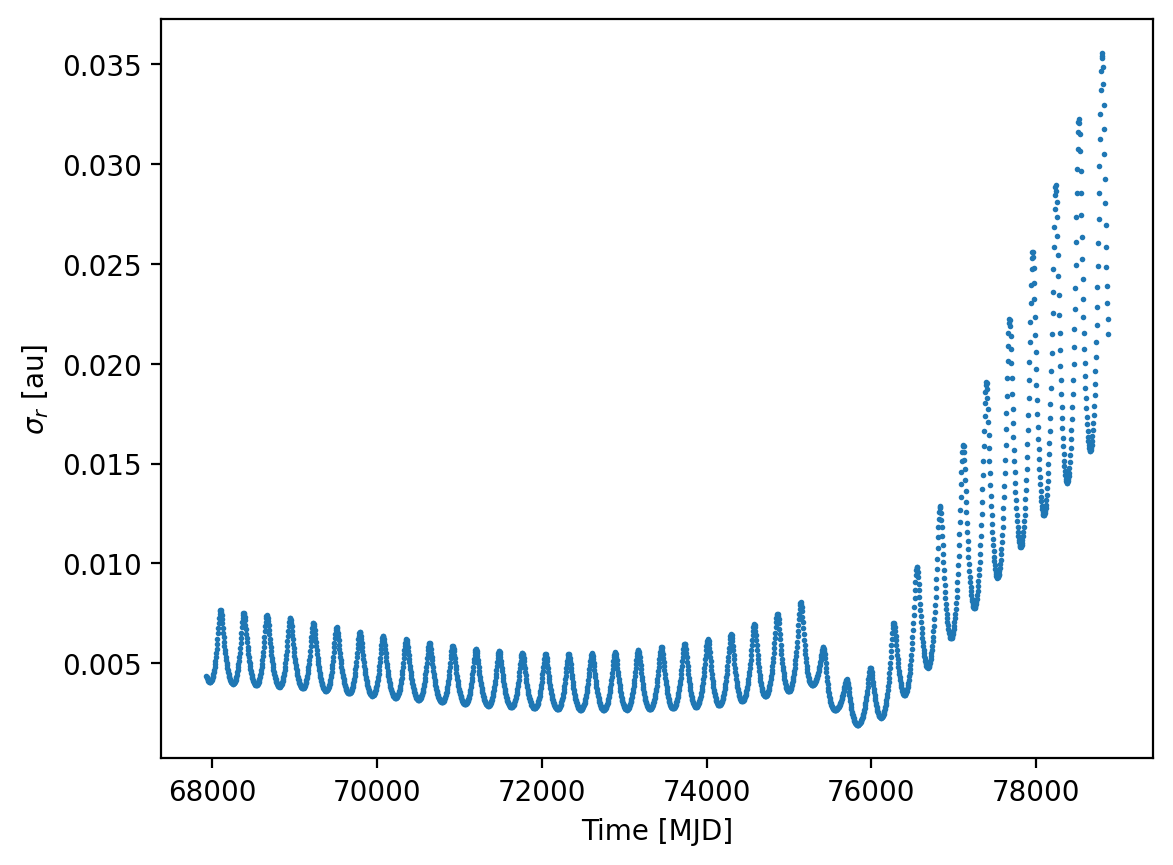

In [8]:
# We can plot how the covariance matrix grows with time (limiting just to the uncertainity in the positional components)
# sigma_r
# Note that after a while the covariance matrix actually poorly approximates the true uncertainty (we get to the point
# where a ring like shape is approximated by a sphere of equal radius..)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(times_mjd, propagated_orbit.coordinates.sigma_r_mag, s=1)
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("$\sigma_r$ [au]")

In [9]:
# Propagated variants 
propagated_variants.to_dataframe().head()

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code
0,000001,(2020 VW),0.477846,0.992941,-0.023493,-0.011122,0.007804,-0.000704,67929,69182556770,None,SUN
1,000002,(2020 VW),0.478448,0.992512,-0.023457,-0.011117,0.007816,-0.000704,67929,69182556770,None,SUN
2,000003,(2020 VW),0.478329,0.992597,-0.023464,-0.011118,0.007814,-0.000704,67929,69182556770,None,SUN
3,000004,(2020 VW),0.485856,0.987112,-0.022996,-0.011052,0.007957,-0.000707,67929,69182556770,None,SUN
4,000005,(2020 VW),0.476932,0.993596,-0.023550,-0.011131,0.007787,-0.000704,67929,69182556770,None,SUN


In [10]:
import os
import spiceypy as sp
from astropy import units as u

import matplotlib.colors 

import pyarrow.compute as pc

from naif_leapseconds import leapseconds
sp.furnsh(leapseconds)

def add_renderable_trail_orbit(
        name: str, 
        object_id: str, 
        target_id: str, 
        kernel_file: str, 
        period: float,
        sample_interval: int = 3600, 
        tag: str = "THOR",
        opacity: float = 1.0,
        rgb: tuple = (1.0, 1.0, 1.0),
        line_width: int = 1,
    ):
    return f"""local {name} = {{
    Identifier = "{object_id}_trail",
    Parent = "SunCenter",
    Renderable = {{
        Type = "RenderableTrailOrbit",
        Enabled = true,
        Translation = {{
            Type = "SpiceTranslation",
            Target = "{target_id}",
            Observer = "SUN",
            Kernels = {{
                asset.localResource("{kernel_file}")
            }},
        }},
        Color = {{{rgb[0]},{rgb[1]},{rgb[2]}}},
        Opacity = {opacity},
        Period = {period},
        Resolution = {sample_interval},
        LineWidth = {line_width},
        SampleInterval = {sample_interval}
    }},
    Opacity = {opacity},
    Tag = {{"{tag}"}},
    GUI = {{
        Name = "trail_{object_id}",
        Path = "/ADAM"
    }}
}}"""

def add_renderable_trail_head( 
        name: str, 
        object_id: str,  
        target_id: str, 
        kernel_file: str, 
        tag: str = "THOR",
    ):
    return f"""local {name} = {{
    Identifier = "{object_id}",
    Parent = "SunCenter",
    Transform = {{
        Translation = {{
            Type = "SpiceTranslation",
            Target = "{target_id}",
            Observer = "SUN",
            Kernels = {{
                asset.localResource("{kernel_file}")
            }},
        }},
    }},
    Tag = {{"{tag}"}},
    GUI = {{
        Name = "{object_id}",
        Path = "/ADAM"
    }}
}}"""


# 60 default for sample_interval
def create_openspace_assets(
        propagated_orbits, 
        out_dir, 
        tag="ADAM",
        sample_interval=86400, 
        color="green", 
        orbit_properties=None, 
        id_offset=1000000,
        line_width=2,
    ):
    os.makedirs(out_dir, exist_ok=True)
    
    out_asset = open(os.path.join(out_dir, "all.asset"), "w")
    out_asset.write("local assetHelper = asset.require('util/asset_helper')\n",)

    orbit_ids = propagated_orbits.orbit_id.unique().to_numpy(zero_copy_only=False)

    if orbit_properties is None or "color" not in orbit_properties.columns:
        colors = [color] * len(orbit_ids)
        rgb = [matplotlib.colors.to_rgb(color) for color in colors]
    else:
        rgb = orbit_properties["color"].values

    if orbit_properties is None or "opacity" not in orbit_properties.columns:
        opacity = [1] * len(orbit_ids)
    else:
        opacity = orbit_properties["opacity"].values

    for i, orbit_id in enumerate(orbit_ids):


        mask = pc.equal(propagated_orbits.orbit_id, orbit_id)
        propagated_orbit = propagated_orbits.apply_mask(mask)
        propagated_orbit = propagated_orbit.sort_by(["coordinates.time.days", "coordinates.time.nanos"])

        keplerian = propagated_orbit.coordinates.to_keplerian()
        orbital_period = keplerian.P[0]
            
        target_id = id_offset + i
        
        epochs_tdb = propagated_orbit.coordinates.time.rescale("tdb").jd().to_numpy(zero_copy_only=False)
        epochs_et = np.array([sp.str2et(f'JD {i:.15f} TDB'.format(i)) for i in epochs_tdb])
        
        states = propagated_orbit.coordinates.values
        states[:, 0:6] *= u.au.to(u.km)
        states[:, 3:6] /= (u.d).to(u.s)

        out_bsp = os.path.join(out_dir, f"{orbit_id}.bsp")
        file = sp.spkopn(out_bsp, f"{target_id}", 0)
        sp.spkw09(
            file, 
            target_id,
            10,
            "ECLIPJ2000",
            epochs_et[0],
            epochs_et[-1],
            "SPK_STATES_09",
            15,
            len(epochs_et),
            np.ascontiguousarray(states),
            epochs_et,
        )
        sp.spkcls(file)
        
        asset = add_renderable_trail_orbit(
            f"trail{i}",
            orbit_id,
            target_id,
            os.path.basename(out_bsp),
            orbital_period * 365.25,
            sample_interval=sample_interval, 
            tag=tag,
            opacity=opacity[i],
            rgb=rgb[i],
            line_width=line_width,
        )
        asset += "\n"
        asset += add_renderable_trail_head(
            f"head{i}",
            orbit_id,
            target_id,
            os.path.basename(out_bsp),
            tag=tag,
        )

        out_asset.write(asset)
        out_asset.write("\n")
        
        asset += "\n"
        asset += f"assetHelper.registerSceneGraphNodesAndExport(asset, {{trail{i}, head{i}}})"
        
        asset_file = open(os.path.join(out_dir, f"{orbit_id}.asset"), "w")
        asset_file.write("local assetHelper = asset.require('util/asset_helper')\n",)
        asset_file.write(asset)
        asset_file.close()
        

    out_asset.write("assetHelper.registerSceneGraphNodesAndExport(asset, {\n")
    for i in range(len(orbit_ids)):
        out_asset.write(f"  trail{i},\n")
        out_asset.write(f"  head{i},\n")
    out_asset.write("})\n")
    out_asset.close()
   
    return 


In [11]:
create_openspace_assets(propagated_orbit, os.path.join(out_dir, "openspace_orbit"), color="blue")
create_openspace_assets(propagated_variants, os.path.join(out_dir, "openspace_variants"))